In [1]:
import os
import pandas as pd
import numpy as np
import math
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import levene
from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import binomtest
from distfit import distfit
import pingouin as pg

In [2]:
original_data = pd.read_csv('survey_results.csv', index_col=0)
original_df = df = pd.DataFrame(original_data) 
original_df.head()

,group,id,question,answer,time,confidence,correct_answer,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,faster_timers,slider_timers,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_clique_si,3,754,1,3,True,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],[],[],16,0,162,0,0,0
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,nl_t3_single_si,1,86,5,1,True,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],[],[],26,8,0,0,0,0
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_tl,3,62,5,3,True,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",10,0,23,0,0,10
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t3_clique_jp,5,605,5,3,False,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],[],[],0,0,100,0,0,0
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,m_t1_single_si,2,40,5,2,True,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],[],[],0,0,10,0,0,0


In [4]:
wrong_answers = ['0d215911-e63c-46ad-a063-653b709f8253',
'037605fd-b893-4885-b04a-8e9c2bed8a1a',
'1039ad57-5293-4af8-acce-89edd244cc7a',
'86bfd834-db2c-44ee-8300-8f182be02533',
'224c8817-b026-4280-b546-04d6cb5388f7',
'2e4f721a-71de-465c-97c1-4bd8a4c7a5d4',
'ffadb36b-5051-4684-b9cf-ed767a599434',
'f357cda5-2402-4fd5-93ff-d8d6ed2a566d']

In [5]:
# remove id's who answered control questions 2&3 wrong
original_df = original_df[~original_df['id'].isin(wrong_answers)]

In [6]:
#filter control questions out
control_questions = ['control1', 'control2', 'control3']
original_df = original_df[~original_df['question'].isin(control_questions)]


original_df['network_enc'] = original_df['question'].str.split('_').str[0]
original_df['task_type'] = original_df['question'].str.split('_').str[1]
original_df['task_entity'] = original_df['question'].str.split('_').str[2]
original_df['temporal_enc'] = original_df['question'].str.split('_').str[3]
original_df['correct'] = original_df['correct'].apply(str).str.lower()
original_df['time'] = original_df['time'].apply(int)

original_df = original_df.drop(['question', 'correct_answer'], axis=1) #'id'
original_df.head()

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,zoom_interactions,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],...,16,0,162,0,0,0,m,t1,clique,si
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],...,26,8,0,0,0,0,nl,t3,single,si
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],...,10,0,23,0,0,10,m,t1,single,tl
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],...,0,0,100,0,0,0,m,t3,clique,jp
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],...,0,0,10,0,0,0,m,t1,single,si


## Functions

In [7]:
def shapiro_wilk(data):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

In [8]:
def levene_test(arr1, arr2, arr3, arr4, center):
    stat, p = levene(arr1, arr2, arr3, arr4, center=center)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

In [9]:
def test_distribution(time_orig, time_trans):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    prob = probplot(time_orig, dist=norm, plot=ax1)
    prob = probplot(time_trans, dist=norm, plot=ax2)

    ax1.set_title('Original Data')
    ax1.set_ylabel('Time Taken')
    ax2.set_title('Transformed Data, λ = %s' % -0.322);
    ax2.set_ylabel('');

In [10]:
def box_cox(df):
    df_trans, lmbda = boxcox(df)
    return df_trans

In [11]:
def remove_outlier_IQR(df, col, lower, upper):
    Q1=df[col].quantile(lower/100)
    Q3=df[col].quantile(upper/100)
    IQR=Q3-Q1
    
    df_final=df[~((df[col]<(Q1-1.5*IQR)) | (df[col]>(Q3+1.5*IQR)))]
    return df_final

In [12]:
def plot_hist(data):
    pyplot.hist(data, bins="sqrt")

In [13]:
def cleanse(df):
    # step 4: IQR outlier removal
    df_old = df
    df = remove_outlier_IQR(df, 'time_trans', 25, 75)
    test_distribution(df_old['time'], df['time_trans'])
    shapiro_wilk(df['time_trans'])

In [14]:
def transform_data(df):
    df['time_trans'] = box_cox(df['time'])
    test_distribution(df['time'], df['time_trans'])

    shapiro_wilk(df['time_trans'])

In [15]:
def check_dist(df):
    dist = distfit(alpha=0.05, stats='RSS')
    dist.fit_transform(df,verbose=1)
    dist.plot(verbose=1)
    dist.summary

In [16]:
def box_plot(df):
    sns.boxplot(x=df)

In [17]:
def skew_and_kurt(df, col):
    sk = skew(df[col])
    kurt = kurtosis(df[col])
    print('Skew: {0}, Kurtosis: {1}'.format(sk, kurt))
    return sk, kurt

In [18]:
def count_plot(df, col):
    sns.countplot(x=col, data=df)

## H1

In [19]:
# step 1: create data groups (nl vs m)
h1_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h1_m_df = original_df.loc[original_df['network_enc'] == 'm']

# step 1.1: further subdivide based on task type
# nl vs m for t1
h1_nl_df_t1 = h1_nl_df.loc[h1_nl_df['task_type'] == 't1']
h1_m_df_t1 = h1_m_df.loc[h1_m_df['task_type'] == 't1']

# nl vs m for t2
h1_nl_df_t2 = h1_nl_df.loc[h1_nl_df['task_type'] == 't2']
h1_m_df_t2 = h1_m_df.loc[h1_m_df['task_type'] == 't2']

# nl vs m for t3
h1_nl_df_t3 = h1_nl_df.loc[h1_nl_df['task_type'] == 't3']
h1_m_df_t3 = h1_m_df.loc[h1_m_df['task_type'] == 't3']

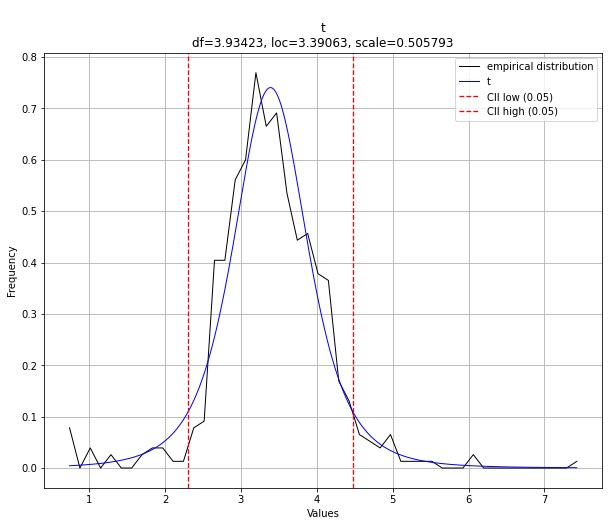

In [20]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t1['time']))

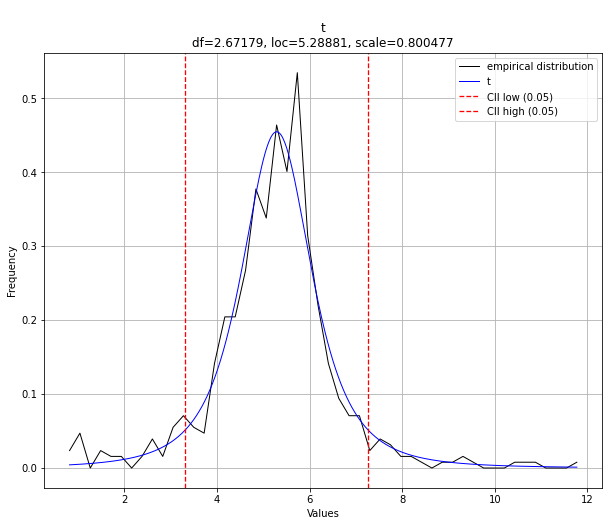

In [21]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t2['time']))

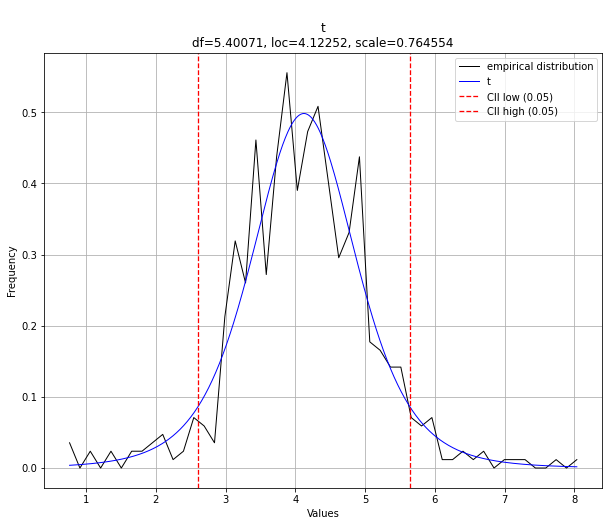

In [22]:
# step 2: check data distribution
check_dist(box_cox(h1_nl_df_t3['time']))

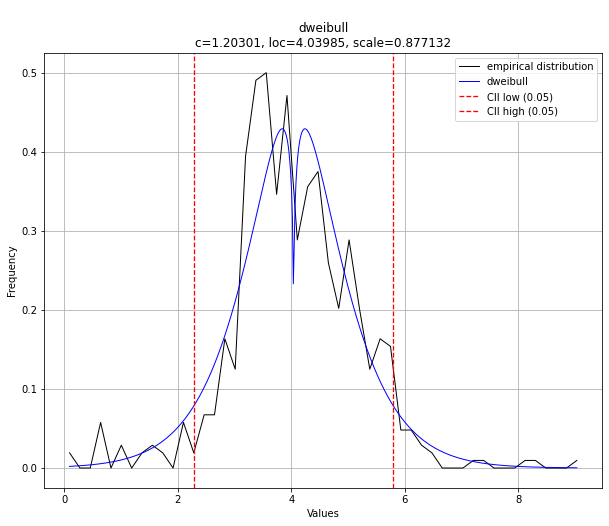

In [23]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t1['time']))

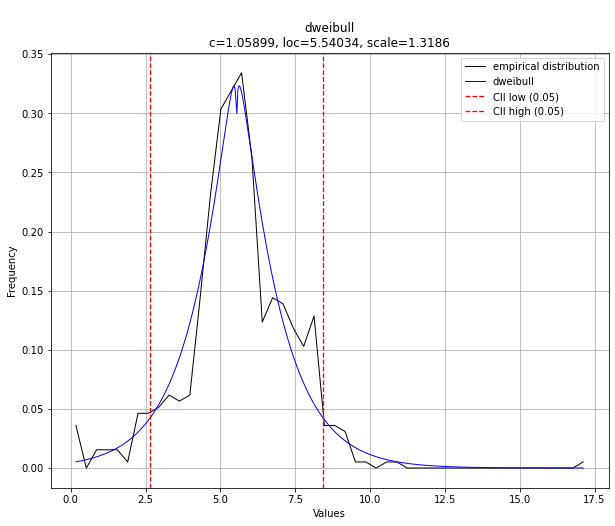

In [24]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t2['time']))

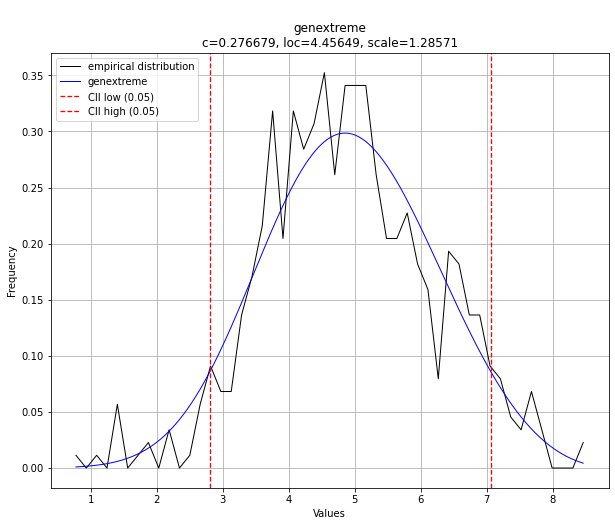

In [25]:
# step 2: check data distribution
check_dist(box_cox(h1_m_df_t3['time']))

Statistics=0.938, p=0.000
Sample does not look Gaussian (reject H0)


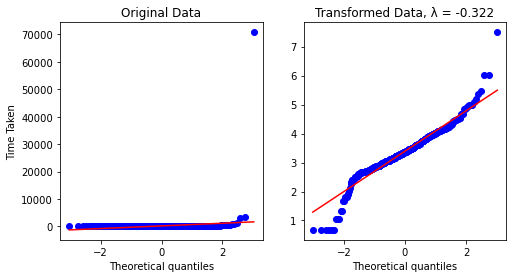

In [26]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t1)

Statistics=0.931, p=0.000
Sample does not look Gaussian (reject H0)


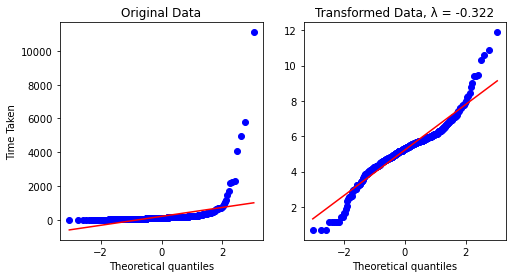

In [27]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t2)

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)


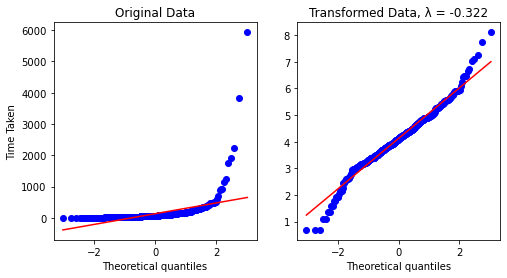

In [28]:
# step 3: transform using box cox and compare before and after
transform_data(h1_nl_df_t3)

Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)


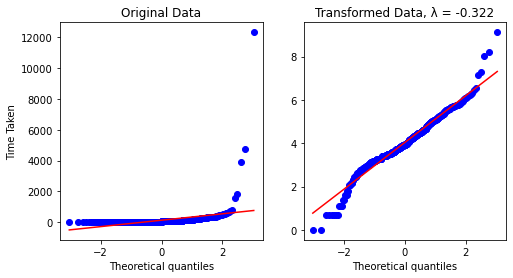

In [29]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t1)

Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)


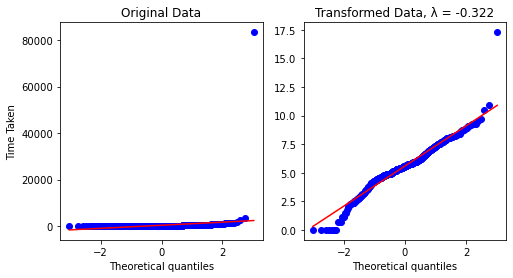

In [30]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t2)

Statistics=0.994, p=0.020
Sample does not look Gaussian (reject H0)


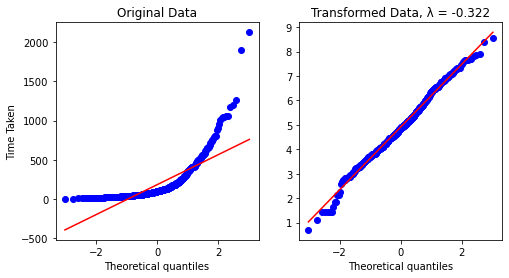

In [31]:
# step 3: transform using box cox and compare before and after
transform_data(h1_m_df_t3)

Statistics=0.991, p=0.002
Sample does not look Gaussian (reject H0)


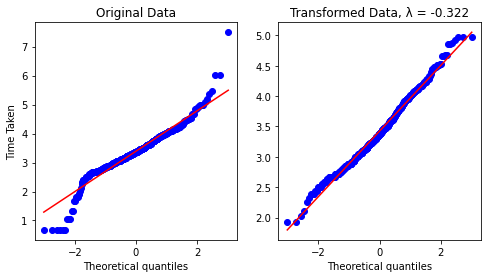

In [32]:
# step 4: IQR outlier removal
h1_nl_df_t1_cleansed = remove_outlier_IQR(h1_nl_df_t1, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t1['time_trans'], h1_nl_df_t1_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t1_cleansed['time_trans'])

Statistics=0.992, p=0.006
Sample does not look Gaussian (reject H0)


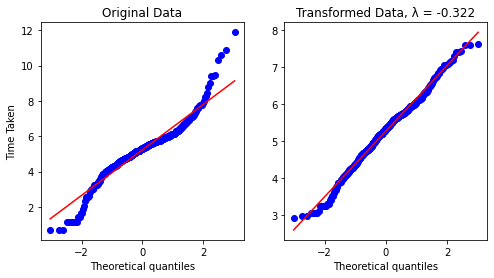

In [33]:
# step 4: IQR outlier removal
h1_nl_df_t2_cleansed = remove_outlier_IQR(h1_nl_df_t2, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t2['time_trans'], h1_nl_df_t2_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t2_cleansed['time_trans'])

Statistics=0.996, p=0.257
Sample looks Gaussian (fail to reject H0)


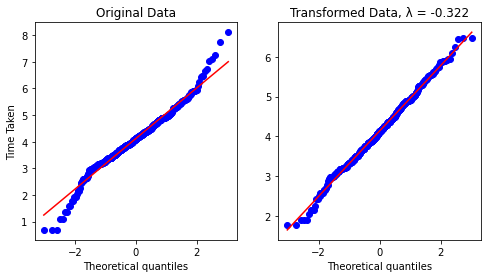

In [34]:
# step 4: IQR outlier removal
h1_nl_df_t3_cleansed = remove_outlier_IQR(h1_nl_df_t3, 'time_trans', 25, 75)
test_distribution(h1_nl_df_t3['time_trans'], h1_nl_df_t3_cleansed['time_trans'])
shapiro_wilk(h1_nl_df_t3_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


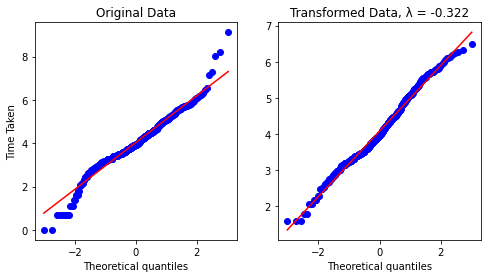

In [35]:
# step 4: IQR outlier removal
h1_m_df_t1_cleansed = remove_outlier_IQR(h1_m_df_t1, 'time_trans', 25, 75)
test_distribution(h1_m_df_t1['time_trans'], h1_m_df_t1_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t1_cleansed['time_trans'])

Statistics=0.988, p=0.000
Sample does not look Gaussian (reject H0)


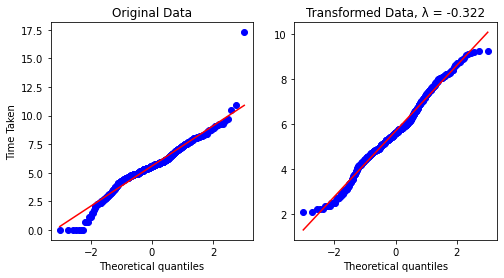

In [36]:
# step 4: IQR outlier removal
h1_m_df_t2_cleansed = remove_outlier_IQR(h1_m_df_t2, 'time_trans', 25, 75)
test_distribution(h1_m_df_t2['time_trans'], h1_m_df_t2_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t2_cleansed['time_trans'])

Statistics=0.991, p=0.002
Sample does not look Gaussian (reject H0)


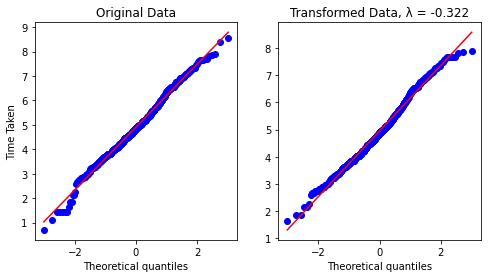

In [37]:
# step 4: IQR outlier removal
h1_m_df_t3_cleansed = remove_outlier_IQR(h1_m_df_t3, 'time_trans', 25, 75)
test_distribution(h1_m_df_t3['time_trans'], h1_m_df_t3_cleansed['time_trans'])
shapiro_wilk(h1_m_df_t3_cleansed['time_trans'])

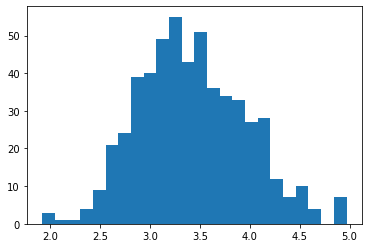

In [38]:
plot_hist(h1_nl_df_t1_cleansed['time_trans'])

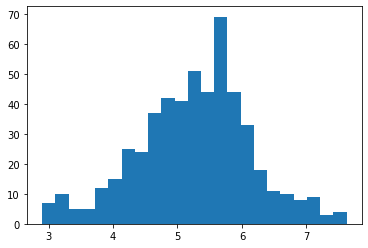

In [39]:
plot_hist(h1_nl_df_t2_cleansed['time_trans'])

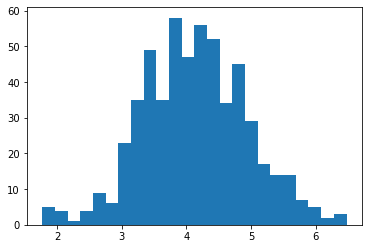

In [40]:
plot_hist(h1_nl_df_t3_cleansed['time_trans'])

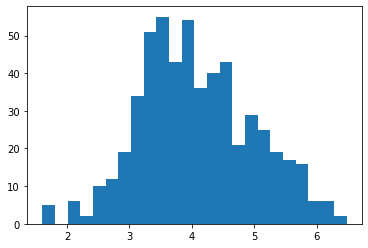

In [41]:
plot_hist(h1_m_df_t1_cleansed['time_trans'])

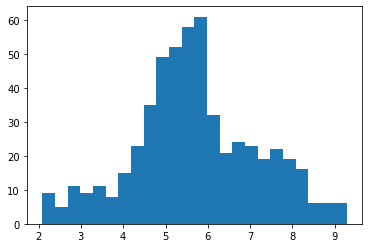

In [42]:
plot_hist(h1_m_df_t2_cleansed['time_trans'])

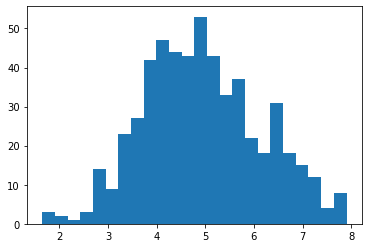

In [43]:
plot_hist(h1_m_df_t3_cleansed['time_trans'])

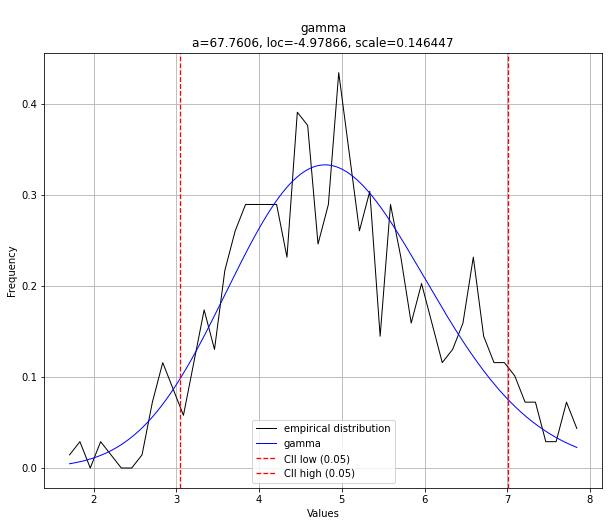

In [44]:
check_dist(h1_m_df_t3_cleansed['time_trans'])

In [45]:
print('NL T1')
skew_and_kurt(h1_nl_df_t1_cleansed, 'time_trans')
print('NL T2')
skew_and_kurt(h1_nl_df_t2_cleansed, 'time_trans')
print('NL T2')
skew_and_kurt(h1_nl_df_t3_cleansed, 'time_trans')
print('M T1')
skew_and_kurt(h1_m_df_t1_cleansed, 'time_trans')
print('M T2')
skew_and_kurt(h1_m_df_t2_cleansed, 'time_trans')
print('M T3')
skew_and_kurt(h1_m_df_t2_cleansed, 'time_trans')

NL T1
Skew: 0.28280103108977, Kurtosis: -0.11438524456072585
NL T2
Skew: -0.1608722564333692, Kurtosis: 0.09407685260650656
NL T2
Skew: 0.03442294228905598, Kurtosis: 0.0569619023830934
M T1
Skew: 0.16867817900011137, Kurtosis: -0.2635657010273915
M T2
Skew: 0.04178687193959833, Kurtosis: -0.11148388707619405
M T3
Skew: 0.04178687193959833, Kurtosis: -0.11148388707619405


(0.04178687193959833, -0.11148388707619405)

Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.996, p=0.000
Sample does not look Gaussian (reject H0)


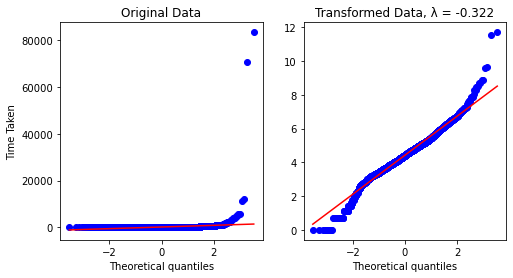

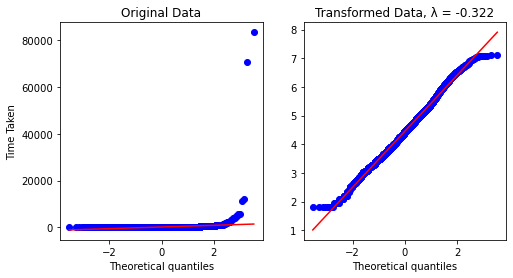

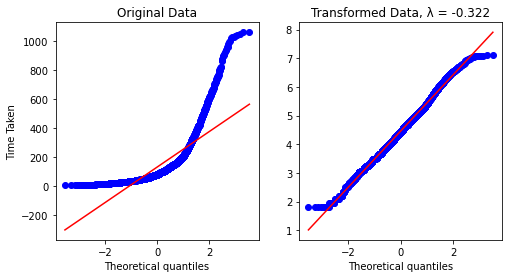

In [46]:
# step 4: IQR outlier removal
transform_data(original_df)
original_df_cleansed = remove_outlier_IQR(original_df, 'time_trans', 25, 75)
test_distribution(original_df['time'], original_df_cleansed['time_trans'])
test_distribution(original_df_cleansed['time'], original_df_cleansed['time_trans'])
shapiro_wilk(original_df_cleansed['time_trans'])

In [47]:
# # check if nl vs m is different
# pg.friedman(data=original_df, dv="time_trans", within=["network_enc", "task_type"], method="chisq")

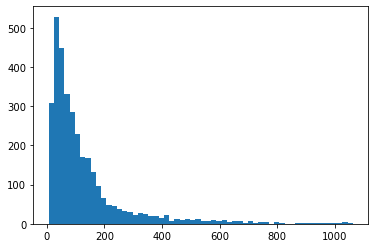

In [48]:
plot_hist(original_df_cleansed['time'])

In [49]:
# check if tasks are different in nl and m
# pg.friedman(data=h1_nl_df, dv="time_trans", within="task_type")

In [50]:
# friedman(data=h1_m_df, dv="time_trans", within="task_type")

In [51]:
# H0: NL[time] === M[time]
# H1: NL[time] !== M[time]
mannwhitneyu(h1_nl_df['time'], h1_m_df['time'], alternative="two-sided") # 0.00000460934 << 0.05 -> reject H0 assume not equal

MannwhitneyuResult(statistic=1309116.0, pvalue=4.609345345004485e-06)

In [52]:
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="two-sided") # ~0.014-> reject? << 0.05 -> reject H0

MannwhitneyuResult(statistic=146618.5, pvalue=0.01373449431040529)

In [53]:
# H0 NL_T1[time] >= M_T1[time]
# H1.1 NL_T1[time] < M_T1[time]
mannwhitneyu(h1_nl_df_t1['time'], h1_m_df_t1['time'], alternative="less") # 0.006867247155202645 -> reject?

MannwhitneyuResult(statistic=146618.5, pvalue=0.006867247155202645)

<AxesSubplot:xlabel='time', ylabel='network_enc'>

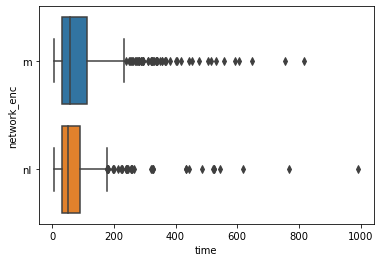

In [54]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='correct', ylabel='count'>

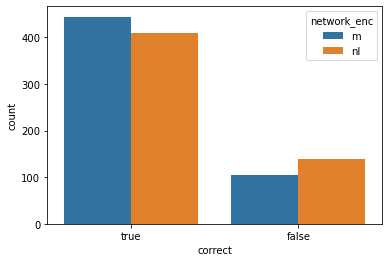

In [55]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't1'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

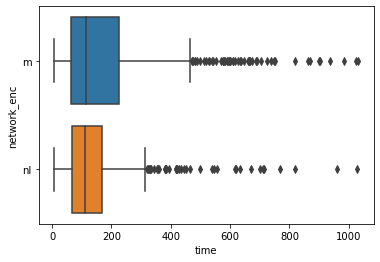

In [56]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

<AxesSubplot:xlabel='correct', ylabel='count'>

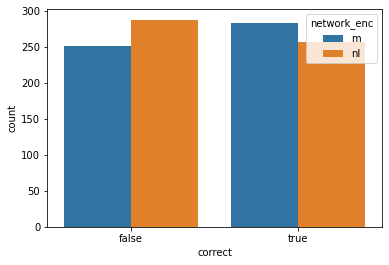

In [57]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't2'])

<AxesSubplot:xlabel='time', ylabel='network_enc'>

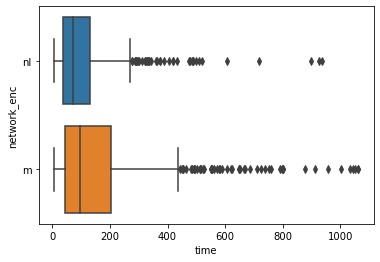

In [58]:
sns.boxplot(x='time', y='network_enc', data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

<AxesSubplot:xlabel='correct', ylabel='count'>

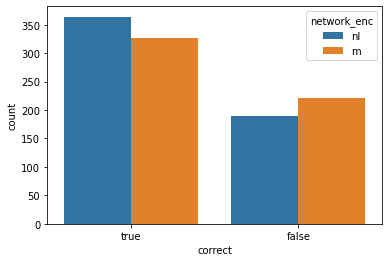

In [59]:
sns.countplot(x="correct", hue="network_enc", data=original_df_cleansed[original_df_cleansed['task_type'] == 't3'])

In [60]:
# H0 NL_T2[time] >= M_T2[time]
# H1.2 NL_T2[time] < M_T2[time]
mannwhitneyu(h1_nl_df_t2['time'], h1_m_df_t2['time'], alternative="less") # 0.16509464970518734 -> approve?

MannwhitneyuResult(statistic=154540.5, pvalue=0.16509464970518734)

In [61]:
# H0 NL_T3[time] >= M_T3[time]
# H1.3 NL_T3[time] < M_T3[time]
mannwhitneyu(h1_nl_df_t3['time'], h1_m_df_t3['time'], alternative="less") # 6.178450282400558e-07 -> reject?

MannwhitneyuResult(statistic=133248.5, pvalue=6.178450282400558e-07)

In [62]:
h1_df = pd.DataFrame()
h1_df = h1_df.append(h1_nl_df_t1_cleansed)
h1_df = h1_df.append(h1_nl_df_t2_cleansed)
h1_df = h1_df.append(h1_nl_df_t3_cleansed)

h1_df = h1_df.append(h1_m_df_t1_cleansed)
h1_df = h1_df.append(h1_m_df_t2_cleansed)
h1_df = h1_df.append(h1_m_df_t3_cleansed)

h1_df

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
7,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,106,5,true,"[1175, 1678]","[3725, 3687, 3773, 3748]",[],[],...,4,0,0,0,0,nl,t1,single,si,3.919000
8,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,151,5,true,"[2725, 158, 348, 185, 169, 66, 685, 84, 698]","[2152, 814, 919]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,3,0,19,0,0,nl,t1,single,an,4.162896
21,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,40,5,true,"[154, 218, 160, 84, 418, 289, 5023, 258, 248]","[1501, 3374]",[],[],...,2,0,0,0,2,nl,t1,single,tl,3.211917
26,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,2,138,4,true,"[160, 259, 287, 165, 1435, 199, 442, 224, 263,...","[3410, 1325, 3685, 3222, 3410, 3499, 3749, 326...",[],[],...,10,0,0,0,0,nl,t1,clique,an,4.101471
32,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,2,19,5,true,"[397, 231, 647, 207, 719]",[],[],[],...,0,0,0,0,0,nl,t1,single,jp,2.634954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3951,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,3,69,3,true,[],[],[],[],...,0,0,0,0,8,m,t3,clique,jp,4.493430
3952,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,5,279,2,false,[],[],[],[],...,0,0,0,0,8,m,t3,clique,an,6.096021
3955,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,3,175,2,false,[],[],[],[],...,0,0,0,0,7,m,t3,clique,si,5.554056
3956,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,4,29,5,true,[],[],[],[],...,0,0,0,0,3,m,t3,single,tl,3.529974


In [63]:
pg.pairwise_tukey(data=h1_df, dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,4.902124,4.266294,0.635829,0.043265,14.696048,1.348810e-12,0.514518


In [64]:
pg.pairwise_tukey(data=h1_df, dv="time_trans", between="task_type")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,t1,t2,3.755959,5.483672,-1.727713,0.045856,-37.677019,0.0,-1.622383
1,t1,t3,3.755959,4.538880,-0.782921,0.045446,-17.227612,0.0,-0.735195
2,t2,t3,5.483672,4.538880,0.944792,0.045681,20.682331,0.0,0.887196


In [65]:
pg.anova(data=h1_df, dv="time_trans", between=["network_enc","task_type"], detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,network_enc,329.075582,1.0,329.075582,320.343867,2.085438e-68,0.062028
1,task_type,1611.949480,2.0,805.974740,784.588949,7.771341e-279,0.303839
2,network_enc * task_type,19.504086,2.0,9.752043,9.493282,7.746302e-05,0.003676
3,Residual,3344.749828,3256.0,1.027257,NaN,NaN,NaN


In [152]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t1"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,6.554343,0.010463


In [153]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t2"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,1.977217,0.159684


In [154]:
pg.kruskal(data=h1_df[h1_df['task_type']=="t3"], dv="time", between="network_enc")

,Source,ddof1,H,p-unc
Kruskal,network_enc,1,26.765387,2.297153e-07


In [155]:
pg.pairwise_ttests(data=h1_df, dv="time", within=["task_type", "network_enc"], subject="id", parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,task_type,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,task_type,-,t1,t2,85.284606,30.049786,163.159311,67.050855,True,True,-11.544792,67.0,greater,1.000000e+00,1.000000e+00,bonf,1.193e-15,-1.490460
1,task_type,-,t1,t3,85.284606,30.049786,139.892603,60.517771,True,True,-10.162489,67.0,greater,1.000000e+00,1.000000e+00,bonf,2.44e-13,-1.136554
2,task_type,-,t2,t3,163.159311,67.050855,139.892603,60.517771,True,True,4.577153,67.0,greater,1.049723e-05,3.149170e-05,bonf,1774.915,0.362251
3,network_enc,-,m,nl,155.607227,67.943940,103.283787,32.587114,True,True,8.989559,67.0,greater,1.997599e-13,NaN,NaN,3.99e+10,0.976472
4,task_type * network_enc,t1,m,nl,97.754231,43.004345,72.814980,26.752045,True,True,5.278165,67.0,greater,7.579609e-07,2.273883e-06,bonf,2.071e+04,0.692482
5,task_type * network_enc,t2,m,nl,195.491071,93.280346,130.827550,50.822639,True,True,7.874833,67.0,greater,2.023261e-11,6.069782e-11,bonf,4.672e+08,0.856047
6,task_type * network_enc,t3,m,nl,173.576377,94.363265,106.208829,40.775591,True,True,6.898670,67.0,greater,1.149434e-09,3.448302e-09,bonf,9.752e+06,0.921608


In [147]:
pg.pairwise_ttests(data=h1_df, dv="time", between=["task_type", "network_enc"], parametric=True, alpha=0.05, alternative="greater", padjust="bonf", correction=True, return_desc=True)

,Contrast,task_type,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,task_type,-,t1,t2,85.863177,91.808317,164.179007,172.141878,False,True,-13.142014,1619.712288,greater,1.000000e+00,1.000000e+00,bonf,1.361e-35,-0.569127
1,task_type,-,t1,t3,85.863177,91.808317,141.562387,172.723875,False,True,-9.453564,1688.885182,greater,1.000000e+00,1.000000e+00,bonf,1.284e-18,-0.401689
2,task_type,-,t2,t3,164.179007,172.141878,141.562387,172.723875,False,True,3.056681,2168.703305,greater,1.132663e-03,3.397988e-03,bonf,9.898,0.131112
3,network_enc,-,m,nl,155.779671,189.524330,104.574429,99.822481,False,True,9.673968,2495.916518,greater,4.662242e-22,NaN,NaN,7.073e+18,0.337285
4,task_type * network_enc,t1,m,nl,97.936479,106.585013,73.498141,71.687877,False,True,4.449218,965.444064,greater,4.810588e-06,1.443176e-05,bonf,2185.133,0.268271
5,task_type * network_enc,t2,m,nl,194.205556,217.807911,133.411765,97.814013,False,True,5.904615,751.885250,greater,2.675042e-09,8.025127e-09,bonf,3.13e+06,0.358383
6,task_type * network_enc,t3,m,nl,175.927536,209.987853,107.321300,115.430939,False,True,6.729558,855.472671,greater,1.557497e-11,4.672492e-11,bonf,4.527e+08,0.404824


In [68]:
pg.ttest(h1_df[h1_df['network_enc']=='m']['time_trans'], h1_df[h1_df['network_enc']=='nl']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.722633,3094.460541,greater,8.973885e-48,"[0.56, inf]",0.514636,1.978e+44,1.0


true     0.643944
false    0.356056
Name: correct, dtype: float64


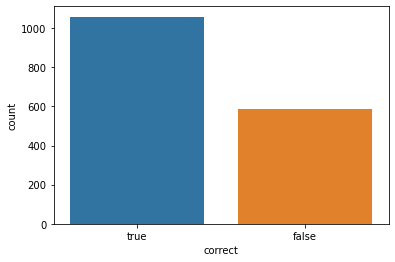

In [69]:
count_plot(h1_df[(h1_df['network_enc']=='m')], 'correct')

# check percentage of correct
print(h1_df[(h1_df['network_enc']=='m')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m')]))

true     0.628166
false    0.371834
Name: correct, dtype: float64


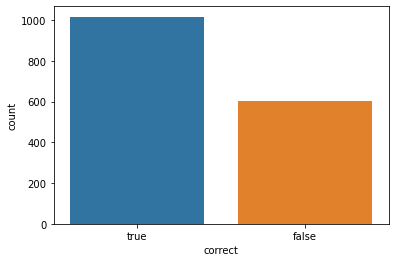

In [70]:
count_plot(h1_df[(h1_df['network_enc']=='nl')], 'correct')

# check percentage of correct
print(h1_df[(h1_df['network_enc']=='nl')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl')]))

In [71]:
success_m, fail_m = h1_df[(h1_df['network_enc']=='m')]['correct'].value_counts()
success_nl, fail_nl = h1_df[(h1_df['network_enc']=='nl')]['correct'].value_counts()
num_trial_m = len(h1_df[(h1_df['network_enc']=='m')])
num_trial_nl = len(h1_df[(h1_df['network_enc']=='nl')])
success_prob_nl, fail_prob_nl = h1_df[(h1_df['network_enc']=='nl')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl')])
success_prob_m, fail_prob_m = h1_df[(h1_df['network_enc']=='m')]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m')])

binomtest(success_m, num_trial_m, p=success_prob_nl, alternative="greater")

BinomTestResult(k=1058, n=1643, alternative='greater', proportion_estimate=0.6439440048691418, pvalue=0.09690749040450224)

In [72]:
task_type = 't3'
success_m, fail_m = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]['correct'].value_counts()
success_nl, fail_nl = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()
num_trial_m = len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)])
num_trial_nl = len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)])
success_prob_nl, fail_prob_nl = h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)])
success_prob_m, fail_prob_m = h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']==task_type)])

binomtest(success_m, num_trial_m, p=success_prob_nl, alternative="less")

BinomTestResult(k=328, n=552, alternative='less', proportion_estimate=0.5942028985507246, pvalue=0.0012194423379743385)

true     0.65704
false    0.34296
Name: correct, dtype: float64


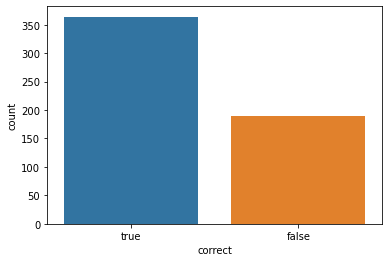

In [73]:
count_plot(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)], 'correct')
print(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]['correct'].value_counts()/len(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']==task_type)]))

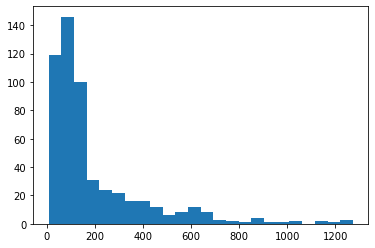

In [74]:
plot_hist(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t2')]['time'])

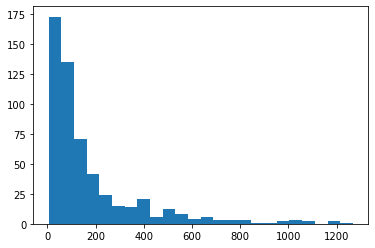

In [75]:
plot_hist(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t3')]['time'])

In [76]:
print(h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t1')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t2')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='m') & (h1_df['task_type']=='t3')]['time_trans'].mean())

4.080011134108357 5.697457793041901 4.944702571908319


In [77]:
print(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t1')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t2')]['time_trans'].mean(),
h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t3')]['time_trans'].mean())

3.4240774642212384 5.264613450281624 4.134522434245693


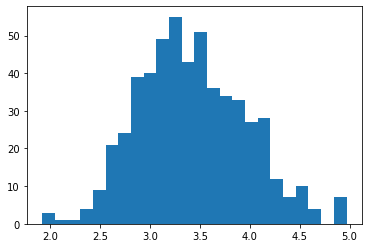

In [78]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t1')]['time_trans'])

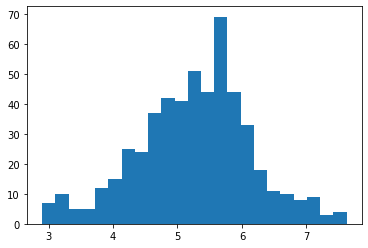

In [79]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t2')]['time_trans'])

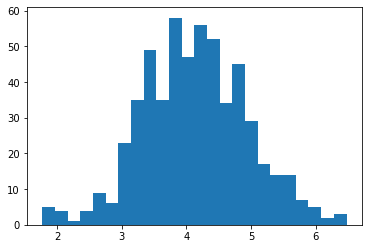

In [80]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['task_type']=='t3')]['time_trans'])

In [81]:
h1_df[(h1_df['network_enc']=='m') & (h1_df['group']=='B')]['time_trans'].mean()

4.936188059507523

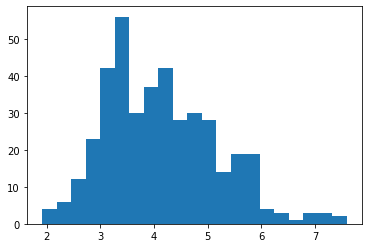

In [82]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='A')]['time_trans'])

In [83]:
h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='A')]['time_trans'].mean()

4.143076028303441

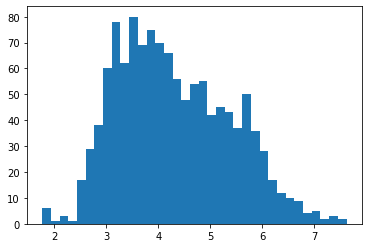

In [84]:
plot_hist(h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='B')]['time_trans'])

In [85]:
h1_df[(h1_df['network_enc']=='nl') & (h1_df['group']=='B')]['time_trans'].mean()

4.307536294419091

## H2

In [86]:
# step 1: create data groups (si vs jp vs tl vs an)
h2_si_df = original_df.loc[original_df['temporal_enc'] == 'si']
h2_jp_df = original_df.loc[original_df['temporal_enc'] == 'jp']
h2_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h2_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

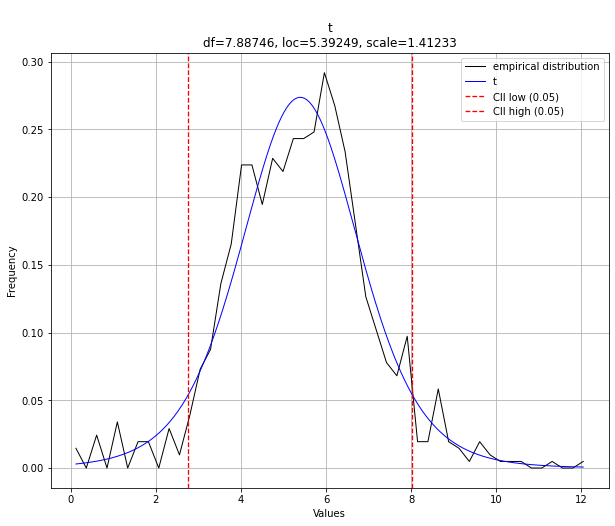

In [87]:
# step 2: check data distribution
check_dist(box_cox(h2_si_df['time']))

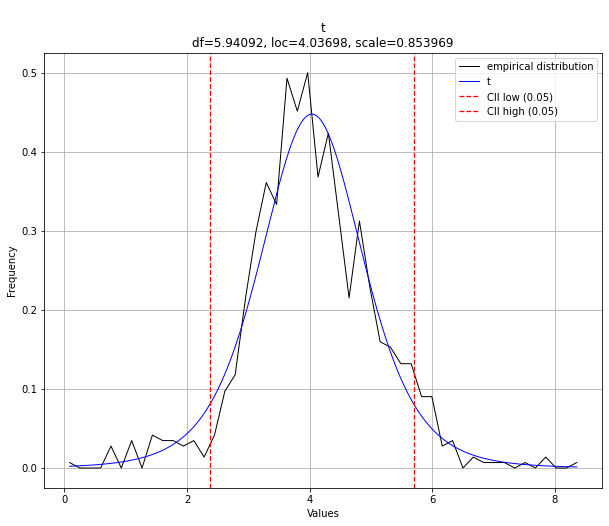

In [88]:
# step 2: check data distribution
check_dist(box_cox(h2_jp_df['time']))

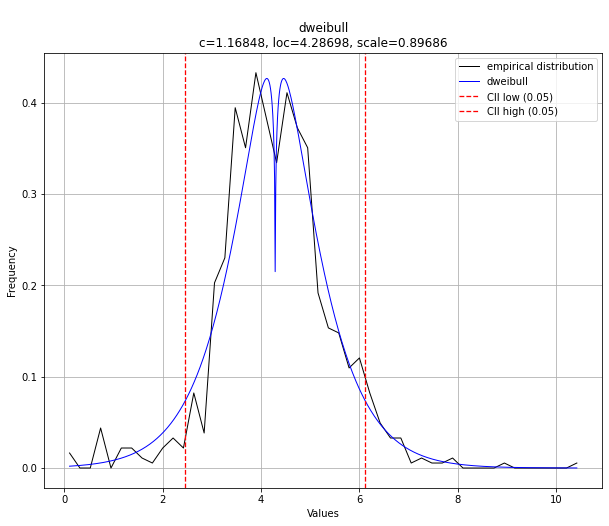

In [89]:
# step 2: check data distribution
check_dist(box_cox(h2_tl_df['time']))

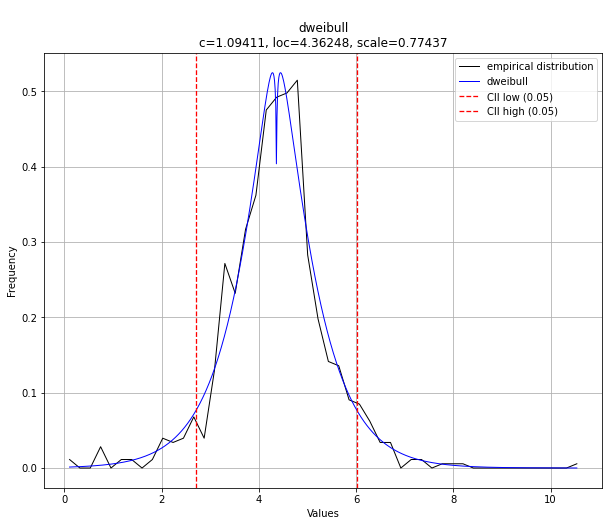

In [90]:
# step 2: check data distribution
check_dist(box_cox(h2_an_df['time']))

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


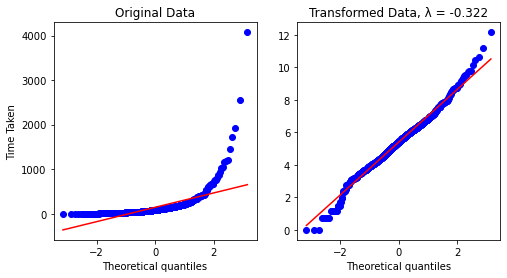

In [91]:
# step 3: transform using box cox and compare before and after
transform_data(h2_si_df)

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


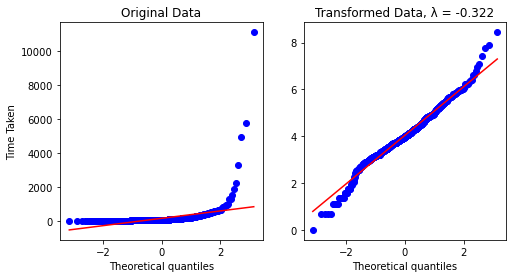

In [92]:
# step 3: transform using box cox and compare before and after
transform_data(h2_jp_df)

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


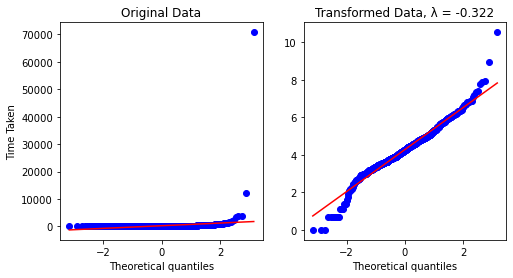

In [93]:
# step 3: transform using box cox and compare before and after
transform_data(h2_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


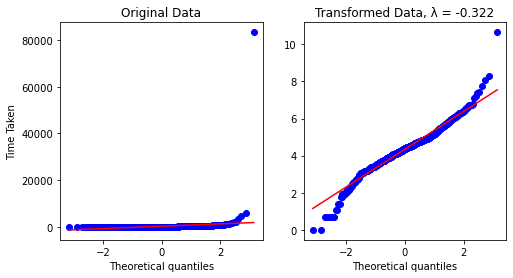

In [94]:
# step 3: transform using box cox and compare before and after
transform_data(h2_an_df)

Statistics=0.996, p=0.060
Sample looks Gaussian (fail to reject H0)


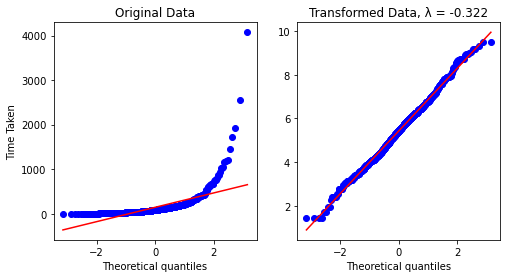

In [95]:
# step 4: IQR outlier removal
h2_si_df_cleansed = remove_outlier_IQR(h2_si_df, 'time_trans', 25, 75)
test_distribution(h2_si_df['time'], h2_si_df_cleansed['time_trans'])
shapiro_wilk(h2_si_df_cleansed['time_trans'])

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)


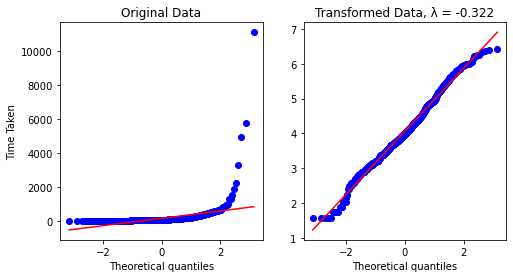

In [96]:
# step 4: IQR outlier removal
h2_jp_df_cleansed = remove_outlier_IQR(h2_jp_df, 'time_trans', 25, 75)
test_distribution(h2_jp_df['time'], h2_jp_df_cleansed['time_trans'])
shapiro_wilk(h2_jp_df_cleansed['time_trans'])

Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)


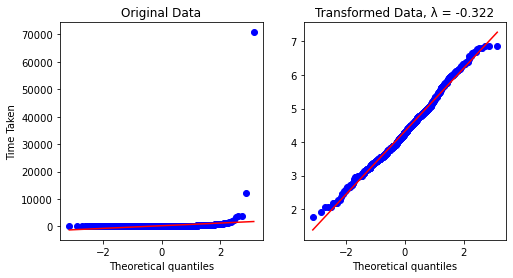

In [97]:
# step 4: IQR outlier removal
h2_tl_df_cleansed = remove_outlier_IQR(h2_tl_df, 'time_trans', 25, 75)
test_distribution(h2_tl_df['time'], h2_tl_df_cleansed['time_trans'])
shapiro_wilk(h2_tl_df_cleansed['time_trans'])

Statistics=0.995, p=0.011
Sample does not look Gaussian (reject H0)


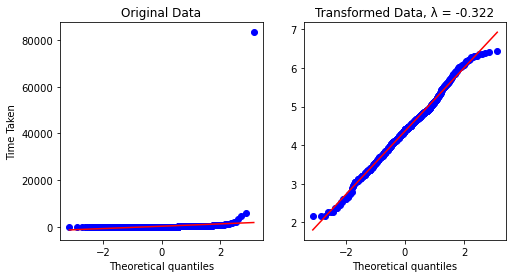

In [98]:
# step 4: IQR outlier removal
h2_an_df_cleansed = remove_outlier_IQR(h2_an_df, 'time_trans', 25, 75)
test_distribution(h2_an_df['time'], h2_an_df_cleansed['time_trans'])
shapiro_wilk(h2_an_df_cleansed['time_trans'])

In [99]:
h2_df = pd.DataFrame()
h2_df = h2_df.append(h2_si_df_cleansed)
h2_df = h2_df.append(h2_jp_df_cleansed)
h2_df = h2_df.append(h2_tl_df_cleansed)
h2_df = h2_df.append(h2_an_df_cleansed)

h2_df

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],...,0,162,0,0,0,m,t1,clique,si,8.943646
1,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,1,86,5,true,"[156, 249, 310, 327, 1317, 177, 248, 243, 164,...","[4407, 3694, 3410, 3901, 2870, 701, 3894, 4036]",[],[],...,8,0,0,0,0,nl,t3,single,si,5.433607
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],...,0,10,0,0,0,m,t1,single,si,4.344969
7,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,106,5,true,"[1175, 1678]","[3725, 3687, 3773, 3748]",[],[],...,4,0,0,0,0,nl,t1,single,si,5.743717
12,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,118,4,false,"[159, 153, 161, 393, 150, 159, 1020, 179]",[],"[364, 300, 230, 233, 261, 365, 227, 698, 200, ...",[],...,0,30,0,0,0,m,t2,single,si,5.904964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,2,26,4,true,[],[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.199790
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,2,374,4,true,[],[],[],[],...,0,0,0,0,3,nl,t3,single,an,5.733358
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,5,125,2,false,[],[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.701001
3965,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,4,202,5,true,[],[],[],[],...,0,0,0,0,23,nl,t1,single,an,5.154657


In [100]:
pg.pairwise_tukey(data=h2_df, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,an,jp,4.364871,4.068466,0.296405,0.052331,5.664092,9.618678e-08,0.281382
1,an,si,4.364871,5.425050,-1.060179,0.052424,-20.223148,2.049694e-12,-1.006445
2,an,tl,4.364871,4.328304,0.036567,0.052177,0.700832,8.967780e-01,0.034714
3,jp,si,4.068466,5.425050,-1.356584,0.051873,-26.152038,2.049694e-12,-1.287840
4,jp,tl,4.068466,4.328304,-0.259837,0.051624,-5.033309,3.031563e-06,-0.246671
5,si,tl,5.425050,4.328304,1.096746,0.051718,21.206132,2.049694e-12,1.041172


In [159]:
pg.mwu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="jp"]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,372543.0,two-sided,0.00062,-0.097382,0.548691


In [161]:
pg.mwu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="an"]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,315343.0,two-sided,0.27665,0.031283,0.484358


In [160]:
pg.mwu(x=h2_df[h2_df['temporal_enc']=="si"]['time'], y=h2_df[h2_df['temporal_enc']=="tl"]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,345230.5,two-sided,0.866256,-0.004779,0.502389


In [101]:
pg.anova(data=h2_df, dv="time_trans", between=["temporal_enc","network_enc"], detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,temporal_enc,884.719018,3.0,294.906339,268.508578,8.772510e-156,0.195983
1,network_enc,31.428272,1.0,31.428272,28.615054,9.436753e-08,0.006962
2,temporal_enc * network_enc,6.635014,3.0,2.211671,2.013700,1.098504e-01,0.001470
3,Residual,3591.482017,3270.0,1.098313,NaN,NaN,NaN


In [140]:
pg.pairwise_ttests(data=h2_df, dv="time_trans", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,temporal_enc,an,jp,4.358003,0.322666,4.067777,0.393371,True,True,8.226003,67.0,two-sided,9.417526e-12,5.650516e-11,bonf,9.488e+08,0.802196
1,temporal_enc,an,si,4.358003,0.322666,5.428154,0.614724,True,True,-17.847810,67.0,two-sided,3.693493e-27,2.216096e-26,bonf,9.299e+23,-2.167679
2,temporal_enc,an,tl,4.358003,0.322666,4.319401,0.392583,True,True,1.113443,67.0,two-sided,2.694968e-01,1.000000e+00,bonf,0.241,0.106824
3,temporal_enc,jp,si,4.067777,0.393371,5.428154,0.614724,True,True,-25.009272,67.0,two-sided,1.068844e-35,6.413063e-35,bonf,2.202e+32,-2.621324
4,temporal_enc,jp,tl,4.067777,0.393371,4.319401,0.392583,True,True,-7.778434,67.0,two-sided,6.037924e-11,3.622754e-10,bonf,1.591e+08,-0.636712
5,temporal_enc,si,tl,5.428154,0.614724,4.319401,0.392583,True,True,22.276417,67.0,two-sided,1.094571e-32,6.567425e-32,bonf,2.442e+29,2.137710


In [103]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time_trans'], h2_df[h2_df['temporal_enc']=='jp']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,22.931906,1378.494581,greater,3.775233e-99,"[1.26, inf]",1.131569,4.464e+97,1.0


In [104]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time_trans'], h2_df[h2_df['temporal_enc']=='an']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,18.300261,1309.160586,greater,4.288801e-67,"[0.96, inf]",0.903123,5.528e+64,1.0


In [105]:
pg.ttest(h2_df[h2_df['temporal_enc']=='si']['time_trans'], h2_df[h2_df['temporal_enc']=='tl']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,18.3695,1407.373121,greater,5.017890e-68,"[1.0, inf]",0.905823,2.268e+65,1.0


true     0.621194
false    0.378806
Name: correct, dtype: float64


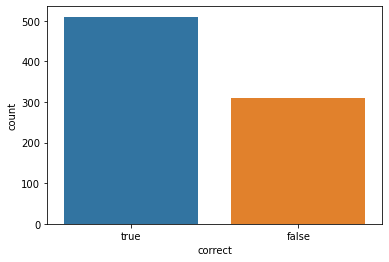

In [106]:
count_plot(h2_df[(h2_df['temporal_enc']=='si')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si')]))

true     0.644498
false    0.355502
Name: correct, dtype: float64


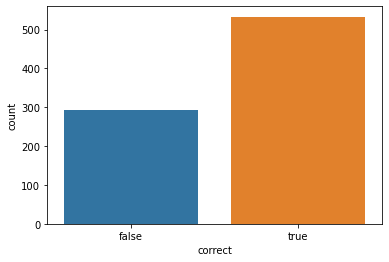

In [107]:
count_plot(h2_df[(h2_df['temporal_enc']=='jp')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp')]))

true     0.686003
false    0.313997
Name: correct, dtype: float64


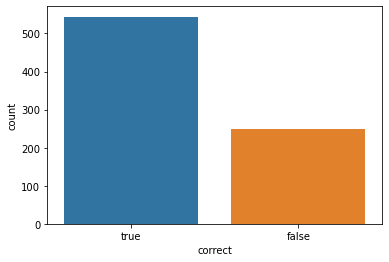

In [108]:
count_plot(h2_df[(h2_df['temporal_enc']=='an')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an')]))

true     0.591398
false    0.408602
Name: correct, dtype: float64


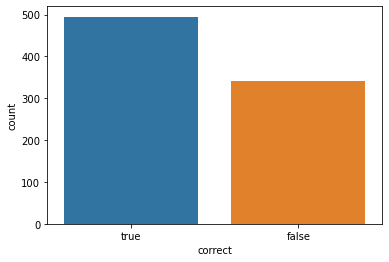

In [109]:
count_plot(h2_df[(h2_df['temporal_enc']=='tl')], 'correct')

# check percentage of correct
print(h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl')]))

In [110]:
success_si, fail_si = h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()
success_jp, fail_jp = h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()
success_tl, fail_tl = h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()
success_an, fail_an = h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()

num_trial_si = len(h2_df[(h2_df['temporal_enc']=='si')])
num_trial_jp = len(h2_df[(h2_df['temporal_enc']=='jp')])
num_trial_tl = len(h2_df[(h2_df['temporal_enc']=='tl')])
num_trial_an = len(h2_df[(h2_df['temporal_enc']=='an')])

success_prob_si, fail_prob_si = h2_df[(h2_df['temporal_enc']=='si')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='si')])
success_prob_jp, fail_prob_jp = h2_df[(h2_df['temporal_enc']=='jp')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='jp')])
success_prob_tl, fail_prob_tl = h2_df[(h2_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='tl')])
success_prob_an, fail_prob_an = h2_df[(h2_df['temporal_enc']=='an')]['correct'].value_counts()/len(h2_df[(h2_df['temporal_enc']=='an')])

In [111]:
binomtest(success_si, num_trial_si, p=success_prob_jp, alternative="greater")

BinomTestResult(k=510, n=821, alternative='greater', proportion_estimate=0.6211936662606578, pvalue=0.923355387202703)

In [112]:
binomtest(success_si, num_trial_si, p=success_prob_tl, alternative="greater")

BinomTestResult(k=510, n=821, alternative='greater', proportion_estimate=0.6211936662606578, pvalue=0.04402897363334911)

In [113]:
binomtest(success_si, num_trial_si, p=success_prob_an, alternative="greater")

BinomTestResult(k=510, n=821, alternative='greater', proportion_estimate=0.6211936662606578, pvalue=0.9999649930386325)

## H3

In [114]:
# step 1: create data groups (tl vs an)
h3_tl_df = original_df.loc[original_df['temporal_enc'] == 'tl']
h3_an_df = original_df.loc[original_df['temporal_enc'] == 'an']

# No difference in time
# TL is more correct than AN

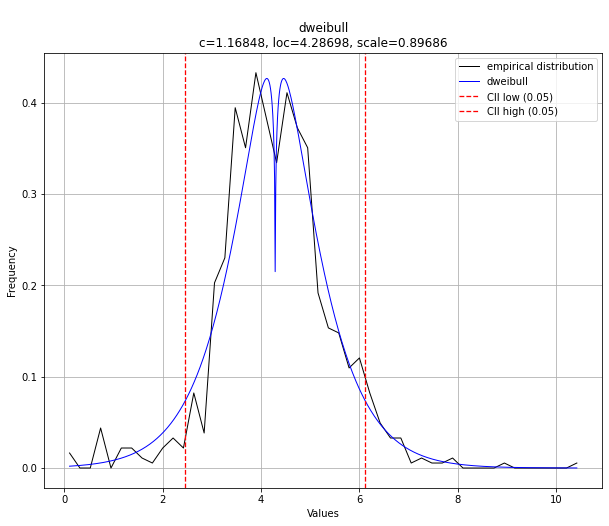

In [115]:
# step 2: check data distribution
check_dist(box_cox(h3_tl_df['time']))

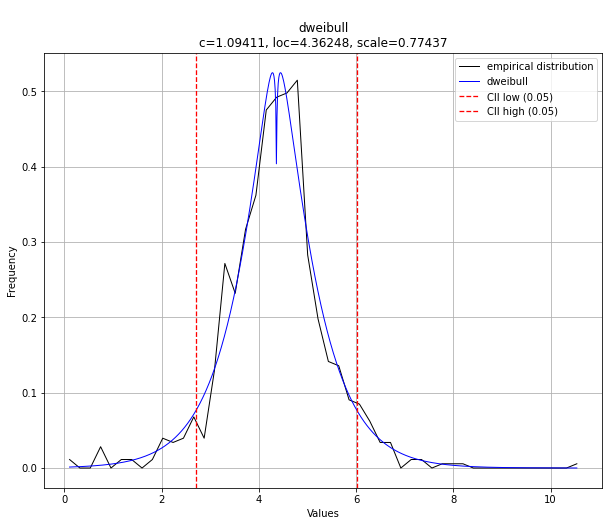

In [116]:
# step 2: check data distribution
check_dist(box_cox(h3_an_df['time']))

Statistics=0.971, p=0.000
Sample does not look Gaussian (reject H0)


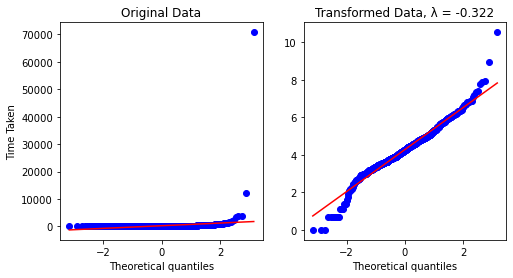

In [117]:
# step 3: transform using box cox and compare before and after
transform_data(h3_tl_df)

Statistics=0.962, p=0.000
Sample does not look Gaussian (reject H0)


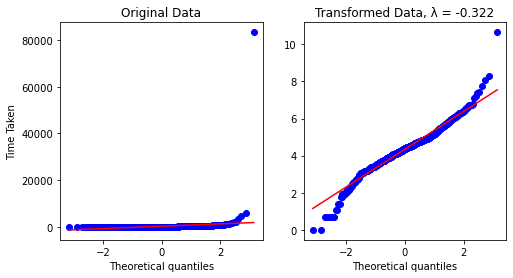

In [118]:
# step 3: transform using box cox and compare before and after
transform_data(h3_an_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


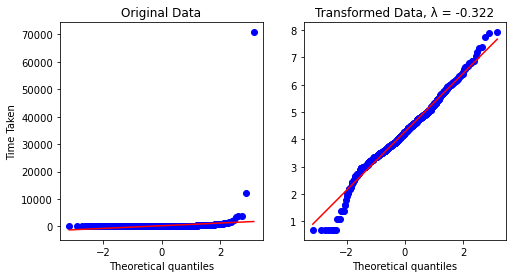

In [119]:
# step 4: IQR outlier removal
h3_tl_df_cleansed = remove_outlier_IQR(h3_tl_df, 'time_trans', 15, 85)
test_distribution(h3_tl_df['time'], h3_tl_df_cleansed['time_trans'])
shapiro_wilk(h3_tl_df_cleansed['time_trans'])

Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)


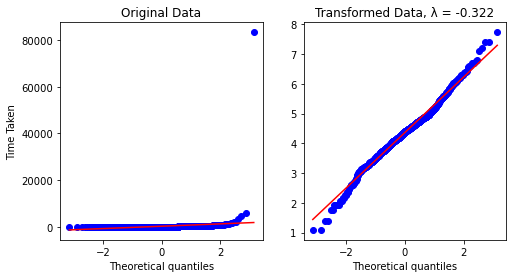

In [120]:
# step 4: IQR outlier removal
h3_an_df_cleansed = remove_outlier_IQR(h3_an_df, 'time_trans', 15, 85)
test_distribution(h3_an_df['time'], h3_an_df_cleansed['time_trans'])
shapiro_wilk(h3_an_df_cleansed['time_trans'])

In [162]:
h3_df = pd.DataFrame()
h3_df = h3_df.append(h3_tl_df_cleansed)
h3_df = h3_df.append(h3_an_df_cleansed)

h3_df

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],...,0,23,0,0,10,m,t1,single,tl,4.037088
5,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,652,4,false,"[155, 158, 414, 151, 2016, 501, 71, 745, 547]",[],"[632, 343, 312, 1063, 994, 18016, 428, 1684, 7...",[],...,0,151,0,0,39,m,t3,clique,tl,6.259902
13,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,1,132,5,true,"[164, 151, 224, 1176]",[],"[201, 796, 1398, 265, 4065, 1500, 213, 799, 35...",[],...,0,69,0,0,0,m,t1,clique,tl,4.757100
14,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,146,4,false,"[1745, 314, 234, 1651, 657]",[3140],[],[],...,1,0,0,0,14,nl,t3,clique,tl,4.852707
15,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,257,4,true,"[218, 327, 454, 331, 775, 229, 204, 151, 1449]",[],"[662, 498, 912, 344, 331, 481, 232, 249, 333, ...",[],...,0,56,0,0,9,m,t2,single,tl,5.387111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,2,26,4,true,[],[],[],[],...,0,0,0,0,3,nl,t3,single,an,3.199790
3959,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,2,374,4,true,[],[],[],[],...,0,0,0,0,3,nl,t3,single,an,5.733358
3961,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,5,125,2,false,[],[],[],[],...,0,0,0,0,3,nl,t2,clique,an,4.701001
3965,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,4,202,5,true,[],[],[],[],...,0,0,0,0,23,nl,t1,single,an,5.154657


In [163]:
pg.pairwise_tukey(data=h3_df, dv="time_trans", between="temporal_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,an,tl,4.366365,4.285321,0.081044,0.049307,1.643651,0.100435,0.080143


In [164]:
pg.mwu(x=h3_df[h3_df['temporal_enc']=="an"]['time'], y=h3_df[h3_df['temporal_enc']=="tl"]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,372762.5,two-sided,0.052057,-0.05473,0.527365


In [165]:
pg.anova(data=h3_df, dv="time_trans", between="temporal_enc", detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,temporal_enc,2.760177,1,2.760177,2.701589,0.100435,0.001606
1,Within,1716.433504,1680,1.021687,NaN,NaN,NaN


In [166]:
pg.pairwise_ttests(data=h3_df, dv="time_trans", within="temporal_enc", subject="id", parametric=True, alpha=0.05, alternative="two-sided", padjust="bonf", correction=True, return_desc=True)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,temporal_enc,an,tl,4.364978,0.378299,4.279367,0.457212,True,True,2.141509,67.0,two-sided,0.035873,1.128,0.202879


In [167]:
pg.ttest(h3_df[h3_df['temporal_enc']=='an']['time_trans'], h3_df[h3_df['temporal_enc']=='tl']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.649567,1665.19473,greater,0.04961,"[0.0, inf]",0.080179,0.422,0.499256


true     0.590487
false    0.409513
Name: correct, dtype: float64


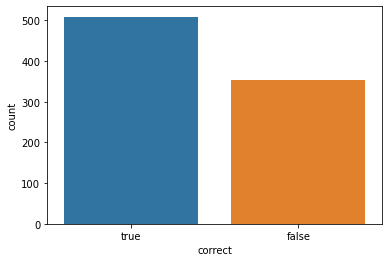

In [168]:
count_plot(h3_df[(h3_df['temporal_enc']=='tl')], 'correct')

# check percentage of correct
print(h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='tl')]))

true     0.680488
false    0.319512
Name: correct, dtype: float64


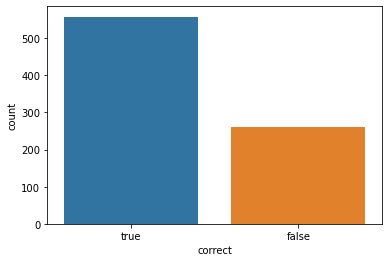

In [169]:
count_plot(h3_df[(h3_df['temporal_enc']=='an')], 'correct')

# check percentage of correct
print(h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='an')]))

In [170]:
success_tl, fail_tl = h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()
success_an, fail_an = h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()

num_trial_tl = len(h3_df[(h3_df['temporal_enc']=='tl')])
num_trial_an = len(h3_df[(h3_df['temporal_enc']=='an')])

success_prob_tl, fail_prob_tl = h3_df[(h3_df['temporal_enc']=='tl')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='tl')])
success_prob_an, fail_prob_an = h3_df[(h3_df['temporal_enc']=='an')]['correct'].value_counts()/len(h3_df[(h3_df['temporal_enc']=='an')])

In [171]:
binomtest(success_tl, num_trial_tl, p=success_prob_an, alternative="greater")

BinomTestResult(k=509, n=862, alternative='greater', proportion_estimate=0.5904872389791184, pvalue=0.999999988527856)

## H4

In [121]:
# step 1: create data groups (a vs b)
h4_a_df = original_df.loc[original_df['group'] == 'A']
h4_b_df = original_df.loc[original_df['group'] == 'B']

# interaction group time >= non-interaction group time (no significant difference)
# interaction group correctness > non-interaction group correctness (significant difference)

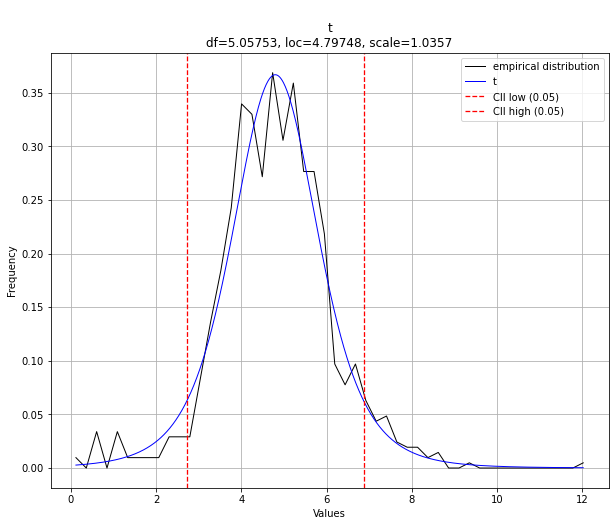

In [122]:
# step 2: check data distribution
check_dist(box_cox(h4_a_df['time']))

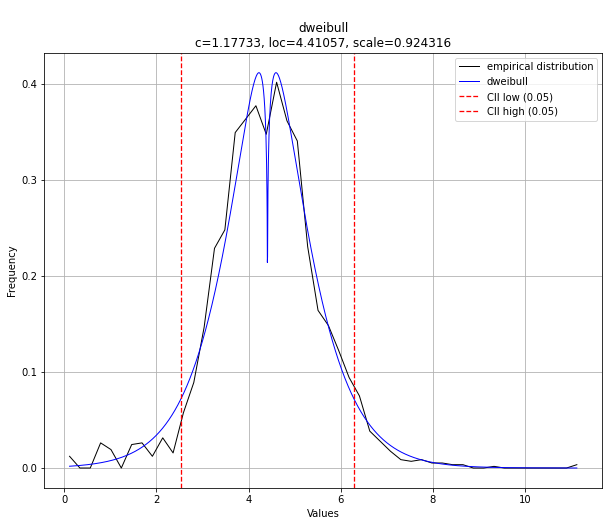

In [123]:
# step 2: check data distribution
check_dist(box_cox(h4_b_df['time']))

Statistics=0.975, p=0.000
Sample does not look Gaussian (reject H0)


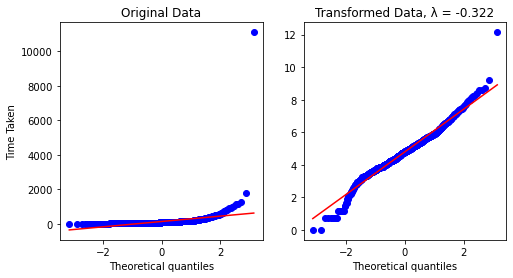

In [124]:
# step 3: transform using box cox and compare before and after
transform_data(h4_a_df)

Statistics=0.979, p=0.000
Sample does not look Gaussian (reject H0)


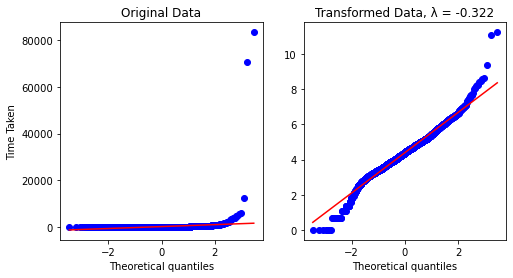

In [125]:
# step 3: transform using box cox and compare before and after
transform_data(h4_b_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


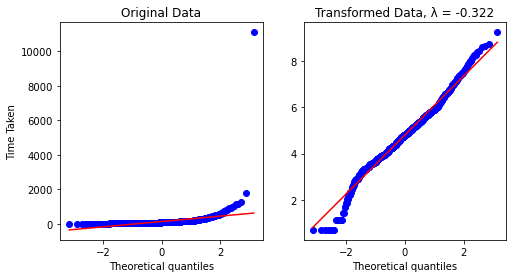

In [126]:
# step 4: IQR outlier removal
h4_a_df_cleansed = remove_outlier_IQR(h4_a_df, 'time_trans', 15, 85)
test_distribution(h4_a_df['time'], h4_a_df_cleansed['time_trans'])
shapiro_wilk(h4_a_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


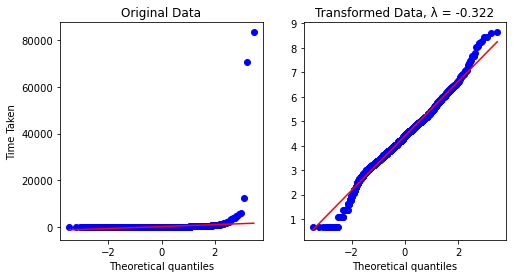

In [127]:
# step 4: IQR outlier removal
h4_b_df_cleansed = remove_outlier_IQR(h4_b_df, 'time_trans', 15, 85)
test_distribution(h4_b_df['time'], h4_b_df_cleansed['time_trans'])
shapiro_wilk(h4_b_df_cleansed['time_trans'])

In [172]:
h4_df = pd.DataFrame()
h4_df = h4_df.append(h4_a_df_cleansed)
h4_df = h4_df.append(h4_b_df_cleansed)

h4_df

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
264,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,1,73,2,false,[],[],[],[],...,0,0,0,0,17,m,t2,single,tl,4.834578
265,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,2,33,4,true,[],[],[],[],...,0,0,0,0,9,nl,t3,single,tl,3.852512
266,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,6,214,2,false,[],[],[],[],...,0,0,0,0,9,nl,t2,clique,an,6.234663
267,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,4,78,3,true,[],[],[],[],...,0,0,0,0,9,nl,t2,single,jp,4.918465
268,A,0fe0c9f2-4f5c-44ab-933d-f0b25f7bbe47,5,99,2,false,[],[],[],[],...,0,0,0,0,19,nl,t3,clique,tl,5.222869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3861,B,f81817ac-49cb-47ed-a599-6b9ba011360d,5,152,5,false,"[1248, 165, 292, 159, 456, 244, 1136, 478, 856...",[2596],[],[],...,1,0,0,0,0,nl,t3,clique,jp,5.006387
3862,B,f81817ac-49cb-47ed-a599-6b9ba011360d,2,27,5,true,"[232, 1799, 238]",[3225],[],[],...,1,0,0,0,0,nl,t1,single,jp,3.288302
3863,B,f81817ac-49cb-47ed-a599-6b9ba011360d,4,52,3,true,"[232, 1799, 238]",[3225],[],[],...,1,0,0,0,0,m,t3,clique,an,3.940417
3864,B,f81817ac-49cb-47ed-a599-6b9ba011360d,4,132,5,true,"[969, 505, 161, 630, 443]",[1350],[],[],...,1,0,0,0,0,nl,t2,single,an,4.866276


In [173]:
pg.pairwise_tukey(data=h4_df, dv="time_trans", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,4.806587,4.403592,0.402994,0.046009,8.759088,0.0,0.347705


In [174]:
pg.mwu(x=h4_df[h4_df['group']=="A"]['time'], y=h4_df[h4_df['group']=="B"]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,973004.0,two-sided,0.000054,0.092605,0.453697


In [176]:
pg.anova(data=h4_df, dv="time_trans", between="group", detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,group,103.015065,1,103.015065,76.721627,3.056824e-18,0.022201
1,Within,4537.024522,3379,1.342712,NaN,NaN,NaN


In [177]:
pg.ttest(h4_df[h4_df['group']=='A']['time_trans'], h4_df[h4_df['group']=='B']['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,8.202833,1305.179438,greater,2.783859e-16,"[0.32, inf]",0.347782,2.189e+13,1.0


true     0.58156
false    0.41844
Name: correct, dtype: float64


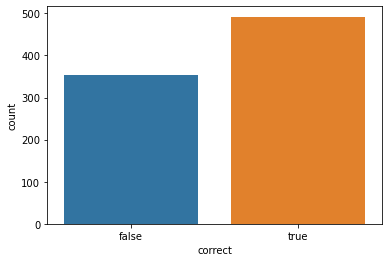

In [178]:
count_plot(h4_df[(h4_df['group']=='A')], 'correct')

# check percentage of correct
print(h4_df[(h4_df['group']=='A')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A')]))

true     0.650493
false    0.349507
Name: correct, dtype: float64


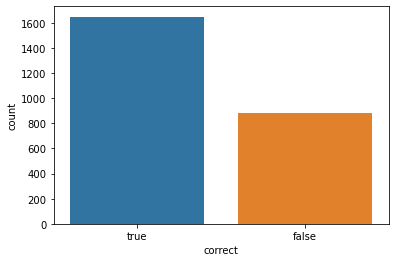

In [179]:
count_plot(h4_df[(h4_df['group']=='B')], 'correct')

# check percentage of correct
print(h4_df[(h4_df['group']=='B')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B')]))

In [182]:
success_a, fail_a = h4_df[(h4_df['group']=='A')]['correct'].value_counts()
success_b, fail_b = h4_df[(h4_df['group']=='B')]['correct'].value_counts()

num_trial_a = len(h4_df[(h4_df['group']=='A')])
num_trial_b = len(h4_df[(h4_df['group']=='B')])

success_prob_a, fail_prob_a = h4_df[(h4_df['group']=='A')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='A')])
success_prob_b, fail_prob_b = h4_df[(h4_df['group']=='B')]['correct'].value_counts()/len(h4_df[(h4_df['group']=='B')])

In [183]:
binomtest(success_a, num_trial_a, p=success_prob_b, alternative="greater")

BinomTestResult(k=492, n=846, alternative='greater', proportion_estimate=0.5815602836879432, pvalue=0.999985953532177)

## H5

In [128]:
# step 1: create data groups (tl vs an)
h5_nl_df = original_df.loc[original_df['network_enc'] == 'nl']
h5_m_df = original_df.loc[original_df['network_enc'] == 'm']

# m_single, m_clique
# nl_single, nl_clique

# m_single time < nl_single time
# m_clique time > nl_clique time

# m_single correctness > nl_single correctness
# m_clique correctness < nl_clique correctness

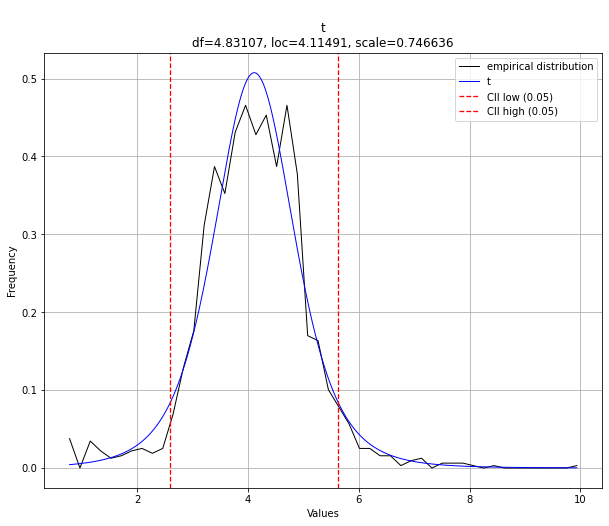

In [129]:
# step 2: check data distribution
check_dist(box_cox(h5_nl_df['time']))

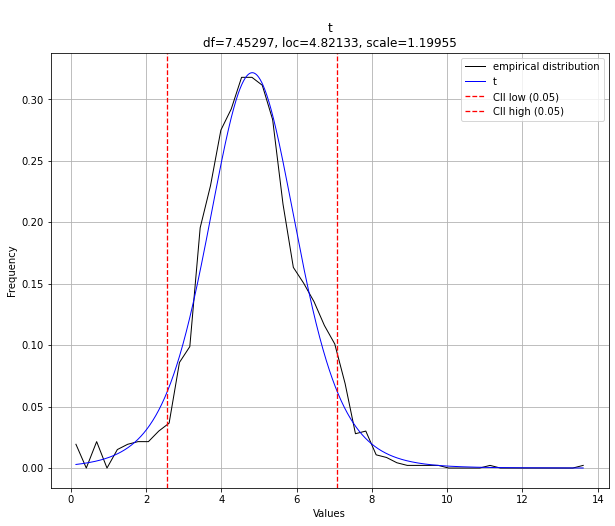

In [130]:
# step 2: check data distribution
check_dist(box_cox(h5_m_df['time']))

Statistics=0.965, p=0.000
Sample does not look Gaussian (reject H0)


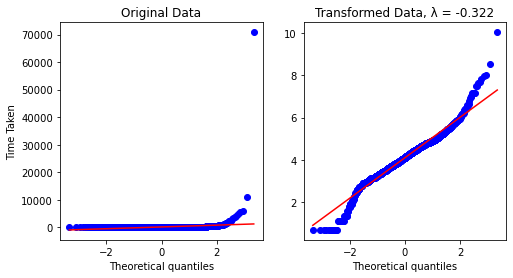

In [131]:
# step 3: transform using box cox and compare before and after
transform_data(h5_nl_df)

Statistics=0.983, p=0.000
Sample does not look Gaussian (reject H0)


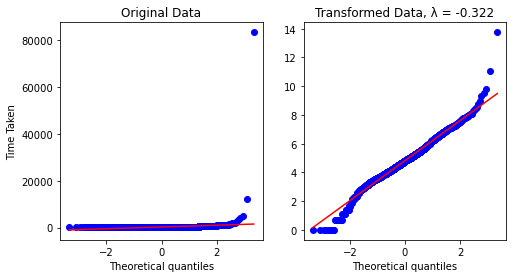

In [132]:
# step 3: transform using box cox and compare before and after
transform_data(h5_m_df)

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


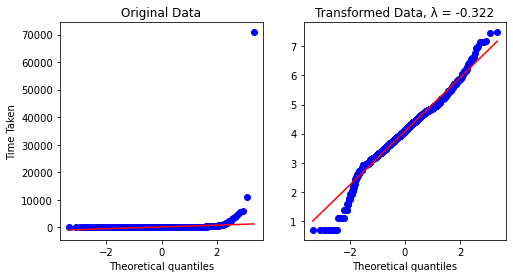

In [133]:
# step 4: IQR outlier removal
h5_nl_df_cleansed = remove_outlier_IQR(h5_nl_df, 'time_trans', 15, 85)
test_distribution(h5_nl_df['time'], h5_nl_df_cleansed['time_trans'])
shapiro_wilk(h5_nl_df_cleansed['time_trans'])

Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)


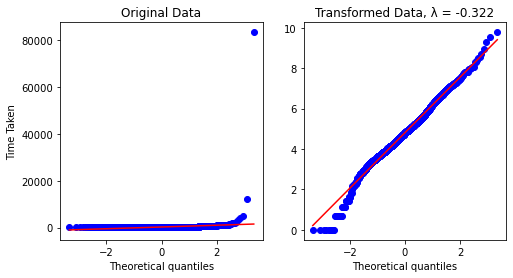

In [134]:
# step 4: IQR outlier removal
h5_m_df_cleansed = remove_outlier_IQR(h5_m_df, 'time_trans', 15, 85)
test_distribution(h5_m_df['time'], h5_m_df_cleansed['time_trans'])
shapiro_wilk(h5_m_df_cleansed['time_trans'])

In [135]:
# step 5: further subdivide based on task type
# single vs clique for nl
h5_nl_single_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'single']
h5_nl_clique_df = h5_nl_df.loc[h5_nl_df['task_entity'] == 'clique']

# single vs clique for m
h5_m_single_df = h5_m_df.loc[h5_m_df['task_entity'] == 'single']
h5_m_clique_df = h5_m_df.loc[h5_m_df['task_entity'] == 'clique']

In [184]:
h5_df = pd.DataFrame()
h5_df = h5_df.append(h5_m_df_cleansed)
h5_df = h5_df.append(h5_nl_df_cleansed)

h5_df

,group,id,answer,time,confidence,correct,zoom_timers,drag_timers,highlight_timers,slower_timers,...,drag_interactions,highlight_interactions,slower_interactions,faster_interactions,slider_interactions,network_enc,task_type,task_entity,temporal_enc,time_trans
0,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,754,1,true,[100],[],"[3400, 429, 8300, 428, 233, 214, 1599, 57199, ...",[],...,0,162,0,0,0,m,t1,clique,si,7.408786
2,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,3,62,5,true,"[156, 151, 203, 318, 162, 159, 158, 277, 1295,...",[],"[315, 381, 516, 279, 915, 551, 284, 277, 367, ...",[],...,0,23,0,0,10,m,t1,single,tl,4.422604
3,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,5,605,5,false,[],[],"[1947, 263, 396, 9420, 464, 364, 25930, 304, 8...",[],...,0,100,0,0,0,m,t3,clique,jp,7.135580
4,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,2,40,5,true,[],[],"[1249, 360, 783, 332, 415, 518, 3727, 481, 114...",[],...,0,10,0,0,0,m,t1,single,si,3.923765
5,B,02f10e19-83e5-48a3-be35-5258e2e89c1a,4,652,4,false,"[155, 158, 414, 151, 2016, 501, 71, 745, 547]",[],"[632, 343, 312, 1063, 994, 18016, 428, 1684, 7...",[],...,0,151,0,0,39,m,t3,clique,tl,7.228197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3966,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,1,38,4,true,[],[],[],[],...,0,0,0,0,23,nl,t3,single,si,3.510913
3968,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,6,47,1,false,[],[],[],[],...,0,0,0,0,23,nl,t2,clique,jp,3.708433
3969,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,4,28,2,false,[],[],[],[],...,0,0,0,0,23,nl,t3,clique,jp,3.225698
3970,A,fd0eab90-ea5f-48cf-9796-8115762f1f51,3,74,1,false,[],[],[],[],...,0,0,0,0,23,nl,t2,clique,si,4.127483


In [191]:
# m_single time < nl_single time
# m_clique time > nl_clique time
pg.pairwise_tukey(data=h5_df[h5_df["task_entity"] == "single"], dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,4.39321,3.842985,0.550225,0.045385,12.123561,3.206324e-13,0.585246


In [192]:
pg.pairwise_tukey(data=h5_df[h5_df["task_entity"] == "clique"], dv="time_trans", between="network_enc")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,m,nl,5.245628,4.335381,0.910247,0.063078,14.430413,1.507683e-13,0.705919


In [195]:
pg.mwu(x=h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['time'], y=h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,404549.5,two-sided,0.00032,-0.10036,0.55018


In [196]:
pg.mwu(x=h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['time'], y=h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['time'], alternative="two-sided")

,U-val,alternative,p-val,RBC,CLES
MWU,412220.5,two-sided,1.078837e-10,-0.18246,0.59123


In [197]:
pg.anova(data=h5_df, dv="time_trans", between=["network_enc","task_entity"], detailed=True, effsize="n2")

,Source,SS,DF,MS,F,p-unc,n2
0,network_enc,448.305166,1.0,448.305166,353.838372,3.743375e-75,0.087189
1,task_entity,382.371744,1.0,382.371744,301.798431,8.057996e-65,0.074366
2,network_enc * task_entity,27.417014,1.0,27.417014,21.639705,3.415808e-06,0.005332
3,Residual,4283.650064,3381.0,1.266977,NaN,NaN,NaN


In [199]:
pg.ttest(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['time_trans'], h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,12.120157,1668.179051,greater,9.148151e-33,"[0.48, inf]",0.585503,2.714e+29,1.0


In [198]:
pg.ttest(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['time_trans'], h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['time_trans'], alternative="greater", correction=True, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,14.430413,1370.650072,greater,2.368708e-44,"[0.81, inf]",0.706237,2.397e+41,1.0


true     0.864486
false    0.135514
Name: correct, dtype: float64


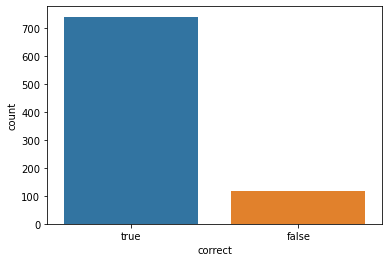

In [201]:
# M SINGLE
count_plot(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]))

false    0.586826
true     0.413174
Name: correct, dtype: float64


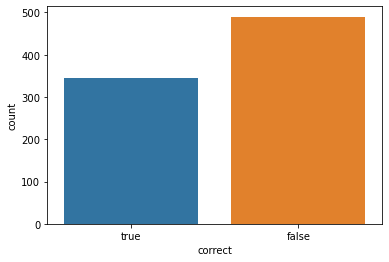

In [200]:
# M CLIQUE
count_plot(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]))

true     0.821886
false    0.178114
Name: correct, dtype: float64


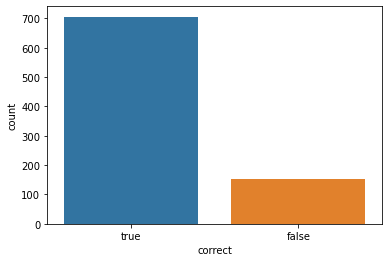

In [202]:
# NL SINGLE
count_plot(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]))

false    0.578443
true     0.421557
Name: correct, dtype: float64


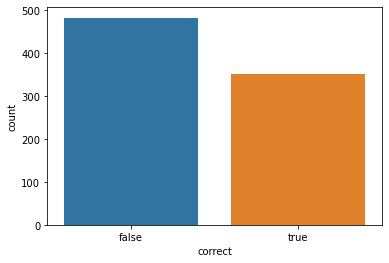

In [203]:
# NL CLIQUE
count_plot(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')], 'correct')

# check percentage of correct
print(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]))

In [204]:
success_m_single, fail_m_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()
success_m_clique, fail_m_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()
success_nl_single, fail_nl_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()
success_nl_clique, fail_nl_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()

num_trial_m_single = len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')])
num_trial_m_clique = len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')])
num_trial_nl_single = len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')])
num_trial_nl_clique = len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')])

success_prob_m_single, fail_prob_m_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='m')])
success_prob_m_clique, fail_prob_m_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='m')])
success_prob_nl_single, fail_prob_nl_single = h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='single') & (h5_df['network_enc']=='nl')])
success_prob_nl_clique, fail_prob_nl_clique = h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')]['correct'].value_counts()/len(h5_df[(h5_df['task_entity']=='clique') & (h5_df['network_enc']=='nl')])

In [205]:
binomtest(success_m_single, num_trial_m_single, p=success_prob_nl_single, alternative="greater")

BinomTestResult(k=740, n=856, alternative='greater', proportion_estimate=0.8644859813084113, pvalue=0.00045975825409672933)

In [206]:
binomtest(success_nl_clique, num_trial_nl_clique, p=success_prob_m_clique, alternative="greater")

BinomTestResult(k=483, n=835, alternative='greater', proportion_estimate=0.578443113772455, pvalue=0.701436355090384)

## H6

In [ ]:
# pairwise tests for time
# M_SI M_JP
# M_SI M_AN
# M_SI M_TL
# M_SI NL_SI
# M_SI NL_JP
# M_SI NL_AN
# M_SI NL_TL
# Alpha = 0.00625 (bonferoni correction for 8 tests)

# binominal for correcctness
# Alpha = 0.00625 (bonferoni correction for 8 tests)

# parse new csv to check preferences of network + temporal encoding